# MODIS file processing

#### First working with the old climatology. (new is formatted wrong)

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')

sys.path.append('/Users/jonahshaw/git_repos/CESM2_analysis/')
sys.path.append('/Users/jonahshaw/git_repos/CESM2_analysis/Common/')

# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, #cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from interp_functions import *

ModuleNotFoundError: No module named 'xesmf'

### Open a single file for processing into cloud histograms

In [2]:
os.getcwd()

'/Users/jonahshaw/git_repos/CESM2_analysis/CESM2_COSP'

In [3]:
ls /Users/jonahshaw/Desktop/rsyncd/

2019GL086423.pdf
20210105_170000_olimpiafinal.cam.h1.2009-06-01-00000.nc
MCD06COSP_M3_MODIS.200207_202006_CLIMO.nc
MCD06COSP_M3_MODIS.A2020001.061.2020181150624.nc
atm_in
clubb_intr.F90
env-analysis_pyngl_ffmpeg.yml
literature_club.mp4


In [4]:
single_modis_path = '/Users/jonahshaw/Desktop/rsyncd/MCD06COSP_M3_MODIS.A2020001.061.2020181150624.nc'
group = 'Cloud_Optical_Thickness_Total'

In [17]:
xr.open_dataset

<function xarray.backends.api.open_dataset(filename_or_obj, group=None, decode_cf=True, mask_and_scale=None, decode_times=True, autoclose=None, concat_characters=True, decode_coords=True, engine=None, chunks=None, lock=None, cache=None, drop_variables=None, backend_kwargs=None, use_cftime=None, decode_timedelta=None)>

In [56]:
single_modis = xr.open_dataset(single_modis_path,group=group,engine='netcdf4')
single_modis_fraction = xr.open_dataset(single_modis_path,group='Cloud_Mask_Fraction',engine='netcdf4')
single_modis_fractionh = xr.open_dataset(single_modis_path,group='Cloud_Mask_Fraction_High',engine='netcdf4')

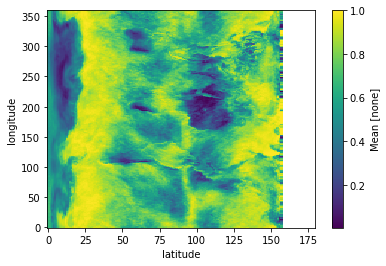

In [55]:
single_modis_fraction['Mean'].plot()

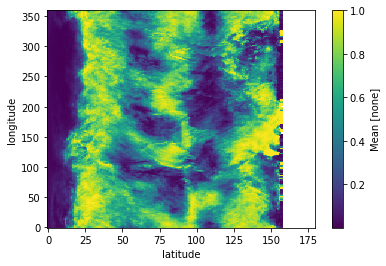

In [57]:
single_modis_fractionh['Mean'].plot() # Cloud Fraction from Cloud Mask (High, CTP LT 440 hPa) for Daytime Scenes

There are several interesting variables here that might be useful in calculating cloud amount:

Mean 'Cloud_Optical_Thickness_Total: Mean': (goes from 0 to 150)  
Sum 'Cloud_Optical_Thickness_Total: Sum' (goes from 0 to 1e6)  
Pixel_Counts 'Cloud_Optical_Thickness_Total: Pixel_Counts' (0 to ~25000)  
Sum_Squares 'Cloud_Optical_Thickness_Total: Sum_Squares' (0 to 1e8)  


In [50]:
print('Sum: ',single_modis['Sum'][0,0].values)

print('Mean: ',single_modis['Mean'][0,0].values)

print('Pixel_Counts: ',single_modis['Pixel_Counts'][0,0].values) # same as summing over the bins

print('Sum_Squares: ',single_modis['Sum_Squares'][0,0].values)


Sum:  4277.099904496223
Mean:  7.451393561840109
Pixel_Counts:  574.0
Sum_Squares:  139689.92274126093


So 'mean' is the average optical depth of the observed clouds.  

'Pixel_Counts' is the counts of the sampled L2 pixels in each L3 grid. (L2 is higher resolution? This is the sum over the bins.)

'Sum' is the sum of the values of the L2 pixels in each L3 grid. (so 'Sum'/'Pixel_Counts' should give 'Mean')

'Sum_Squares' is the sum of the squares of the values of the L2 pixels in each L3 grid (so this is more statistics like and probably useless for me)

I could potentially derived the low-thick clouds by calculating the counts in those bins relative to the total counts and multiplying by the total cloud fraction mask, but that assumes that the clouds fraction for each retrieval is identical (maybe ok on small domains where a gridcell is just 'cloudy' or 'cloud-free', but probably not the best option. I will probably end up reaching out to Robert Pincus.

In [45]:
single_modis['Mean'][0,0]

<xarray.DataArray 'Mean' ()>
array(7.451394)
Attributes:
    title:    Cloud_Optical_Thickness_Total: Mean
    units:    none

In [ ]:
point0 = single_modis

In [22]:
single_modis['JHisto_vs_Cloud_Top_Pressure'].shape

(360, 180, 7, 7)

In [25]:
test_histo = single_modis['JHisto_vs_Cloud_Top_Pressure'][0,0,:,:]

In [28]:
test_histo.attrs

{'title': 'Cloud_Optical_Thickness_Total: JHisto_vs_Cloud_Top_Pressure',
 'JHisto_Bin_Boundaries': array([  0. ,   0.3,   1.3,   3.6,   9.4,  23. ,  60. , 150. ]),
 'JHisto_Bin_Boundaries_Joint_Parameter': array([    0.,   180.,   310.,   440.,   560.,   680.,   800., 10000.])}

In [38]:
test_histo.sum()

<xarray.DataArray 'JHisto_vs_Cloud_Top_Pressure' ()>
array(574.)

Text(0.5, 1.0, 'Cloud_Optical_Thickness_Total: JHisto_vs_Cloud_Top_Pressure')

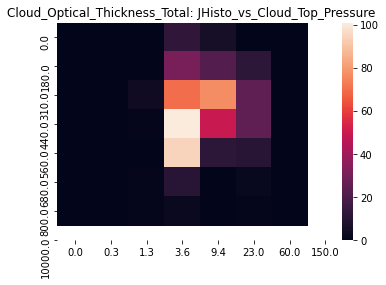

In [34]:
# import numpy as np; 
np.random.seed(0)
# import seaborn as sns; 
# sns.set_theme()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(test_histo,yticklabels=test_histo.attrs['JHisto_Bin_Boundaries_Joint_Parameter'],
                 xticklabels=test_histo.attrs['JHisto_Bin_Boundaries'])

ax.set_title(test_histo.attrs['title'])
# plt.ticklabels(test_histo.attrs['JHisto_Bin_Boundaries_Joint_Parameter'])

## Process MODIS observations

#### There is no time coordinate in this climatology

In [5]:
modis_dir = '/glade/u/home/jonahshaw/w/obs/MODIS/nasa_data'
climo_file = 'MCD06COSP_M3_MODIS.200207_202006_CLIMO.nc'


### The files are group-nested, so they require an additional argument when loading using xarray

In [36]:
# from netCDF4 import Dataset

# source_dataset = Dataset('%s/%s' % (modis_dir,climo_file))
# source_geo_group = source_dataset['/Cloud_Optical_Thickness_PCL_Total/']

Load the correct group.

In [21]:
cloud_histo = xr.open_dataset('%s/%s' % (modis_dir,climo_file),group='Cloud_Optical_Thickness_PCL_Total')

In [25]:
cloud_histo['JHisto_vs_Cloud_Top_Pressure']

<xarray.DataArray 'JHisto_vs_Cloud_Top_Pressure' (longitude: 360, latitude: 180, jhisto_cloud_optical_thickness_pcl_total_7: 7, jhisto_cloud_top_pressure_7: 7)>
[3175200 values with dtype=float64]
Dimensions without coordinates: longitude, latitude, jhisto_cloud_optical_thickness_pcl_total_7, jhisto_cloud_top_pressure_7
Attributes:
    title:                                  Cloud_Optical_Thickness_PCL_Total...
    JHisto_Bin_Boundaries:                  [  0.    0.3   1.3   3.6   9.4  2...
    JHisto_Bin_Boundaries_Joint_Parameter:  [    0.   180.   310.   440.   56...

In [28]:
total_cloud = cloud_histo['JHisto_vs_Cloud_Top_Pressure'].sum(dim=['jhisto_cloud_optical_thickness_pcl_total_7','jhisto_cloud_top_pressure_7'])

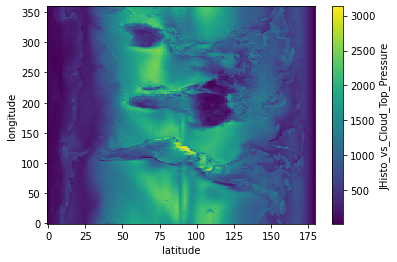

In [30]:
total_cloud.plot()

In [35]:
cloud_histo['JHisto_vs_Cloud_Top_Pressure'][:,:,5:,:3].shape

(360, 180, 2, 3)

In [19]:
source_geo_group.

<class 'netCDF4._netCDF4.Group'>
group /Cloud_Optical_Thickness_PCL_Total:
    long_name: Cloud Optical Thickness for Combined (LiquidWater+Ice+Undetermined) Phase Clouds (3.7 micron Retrieval for Partly Cloudy (PCL) Scenes)
    units: none
    _FillValue: -999.0
    valid_min: 0.0
    valid_max: 150.0
    scale_factor: 1.0
    add_offset: 0.0
    dimensions(sizes): 
    variables(dimensions): int32 JHisto_vs_Cloud_Top_Pressure(longitude,latitude,jhisto_cloud_optical_thickness_pcl_total_7,jhisto_cloud_top_pressure_7)
    groups: 

In [4]:
ls $modis_dir

checksums_501605512
make_avg.csh*
MCD06COSP_M3_MODIS.200207_202006.nc
MCD06COSP_M3_MODIS.A2002182.061.2020181145824.nc
MCD06COSP_M3_MODIS.A2002213.061.2020181145836.nc
MCD06COSP_M3_MODIS.A2002244.061.2020181145835.nc
MCD06COSP_M3_MODIS.A2002274.061.2020181145834.nc
MCD06COSP_M3_MODIS.A2002305.061.2020181145842.nc
MCD06COSP_M3_MODIS.A2002335.061.2020181145833.nc
MCD06COSP_M3_MODIS.A2003001.061.2020181145828.nc
MCD06COSP_M3_MODIS.A2003032.061.2020181145826.nc
MCD06COSP_M3_MODIS.A2003060.061.2020181145844.nc
MCD06COSP_M3_MODIS.A2003091.061.2020181145836.nc
MCD06COSP_M3_MODIS.A2003121.061.2020181145829.nc
MCD06COSP_M3_MODIS.A2003152.061.2020181145835.nc
MCD06COSP_M3_MODIS.A2003182.061.2020181145902.nc
MCD06COSP_M3_MODIS.A2003213.061.2020181145916.nc
MCD06COSP_M3_MODIS.A2003244.061.2020181145926.nc
MCD06COSP_M3_MODIS.A2003274.061.2020181145913.nc
MCD06COSP_M3_MODIS.A2003305.061.2020181145915.nc
MCD06COSP_M3_MODIS.A2003335.061.2020181145902.nc
MCD06COSP_M3_MODIS.A2004001.061.2020181145906.nc

In [4]:
modis_old = xr.open_dataset('%s/%s' % (modis_dir,'MCD03_M3_NC_200207to201007.V01.nc'))

In [10]:
modis_old

<xarray.Dataset>
Dimensions:                                                  (Cloud_Optical_Thickness: 7, Cloud_Top_Pressure: 7, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * lat                                                      (lat) float32 89...
  * lon                                                      (lon) float32 -1...
  * Cloud_Optical_Thickness                                  (Cloud_Optical_Thickness) float32 ...
  * Cloud_Top_Pressure                                       (Cloud_Top_Pressure) float32 ...
Dimensions without coordinates: nbnds
Data variables:
    Cloud_Optical_Thickness_bnds                             (nbnds, Cloud_Optical_Thickness) float32 ...
    Cloud_Top_Pressure_bnds                                  (nbnds, Cloud_Top_Pressure) float32 ...
    Cloud_Top_Pressure_Total_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Total_Mean                           (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Mean                      (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_Mean       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_MeanLog10  (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_MeanLog10                 (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Mean                         (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_Mean          (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_MeanLog10     (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_MeanLog10                    (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_Mean                       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_MeanLog10                  (lat, lon) float32 ...
    Optical_Thickness_vs_Cloud_Top_Pressure                  (lat, lon, Cloud_Top_Pressure, Cloud_Optical_Thickness) float32 ...
    Cloud_Particle_Size_Liquid_Mean                          (lat, lon) float32 ...
    Cloud_Particle_Size_Liquid_Uncertainty_in_Mean           (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Mean                             (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Uncertainty_in_Mean              (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Liquid_Mean                     (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Ice_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Total_Mean                      (lat, lon) float32 ...
    Liquid_Path_Mean                                         (lat, lon) float32 ...
    Liquid_Path_Uncertainty_in_Mean                          (lat, lon) float32 ...
    Ice_Path_Mean                                            (lat, lon) float32 ...
    Ice_Path_Uncertainty_in_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_High_Mean                       (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Mid_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Low_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Mask_High_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Mid_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Mask_Low_Mean                             (lat, lon) float32 ...
Attributes:
    Retrieval_Version:         Collection 51
    Begin_Date:                2002-07-01
    Conventions:               CF-1.4
    Title:                     MODIS cloud observations for climate model eva...
    history:                   Wed Apr  6 15:17:35 2011: ncea -O MCD03_M3_NC....
    nco_openmp_thread_number:  1

### Load CAM data for interpolation

In [5]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

cam4metric = Cloud_Metric(case_dir)
cam4metric.add_case('cam4_1deg_release_amip',label='CAM4')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.


### Plot to trigger variable loading

Could not find variable in GOCCP or CERES-EBAF datasets.


SystemExit: 

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


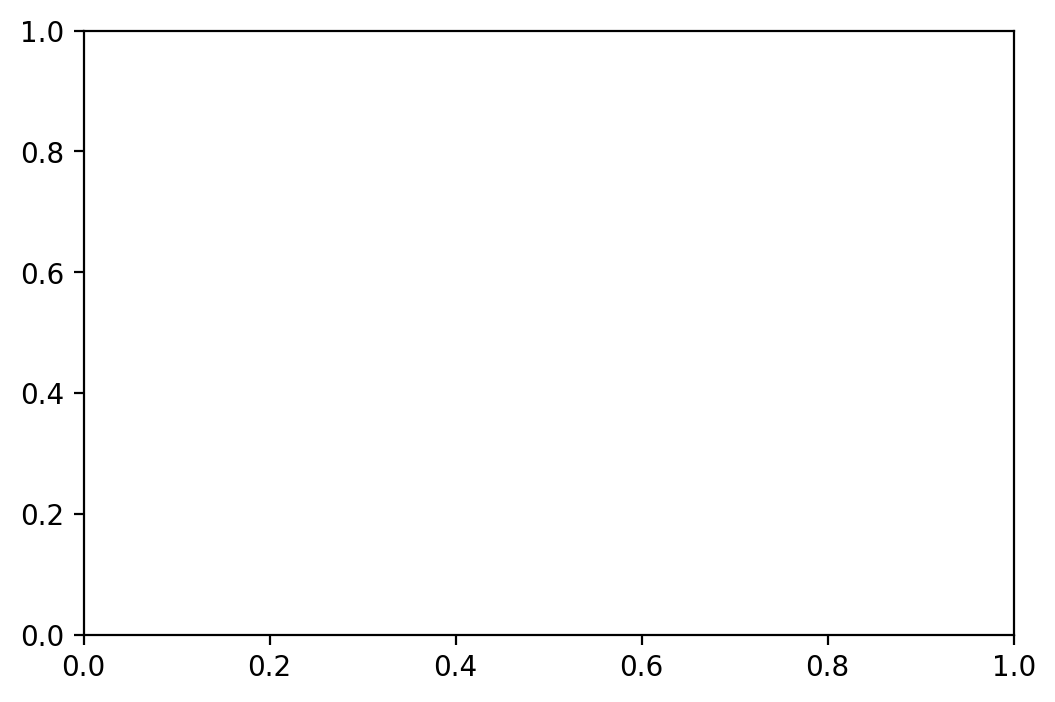

In [7]:
cam4metric.plot1D('CLMODIS');

____

In [8]:
cam4da = cam4metric.get_case('cam4_1deg_release_amip').case_da

In [9]:
cam4da['CLMODIS']

<xarray.DataArray 'CLMODIS' (time: 122, cosp_prs: 7, cosp_tau_modis: 6, lat: 192, lon: 288)>
[283336704 values with dtype=float32]
Coordinates:
  * cosp_prs        (cosp_prs) float64 900.0 740.0 620.0 500.0 375.0 245.0 90.0
  * cosp_tau_modis  (cosp_tau_modis) float64 0.8 2.45 6.5 16.2 41.5 5.003e+04
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2000-12-01 00:00:00 ... 2011-01-01 00:00:00
Attributes:
    mdims:         [12  3]
    units:         %
    long_name:     MODIS Cloud Area Fraction
    cell_methods:  time: mean

## Interpolate to the CAM grid

In [29]:
modis_old_interpd,_ = interp_like2D(modis_old,cam4da['CLMODIS'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


### Copy over dataset-wide attributes

In [30]:
attrs = modis_old.attrs
# print(attrs['Comments'])

datestamp = datetime.today().strftime("%Y/%m/%d")
attrs['Comments'] = 'Interpolated to 1.25x1 deg CESM grid by Jonah Shaw (CU) on %s.' % datestamp
# print(attrs['Comments'])
modis_old_interpd = modis_old_interpd.assign_attrs(attrs)

### Create fake time coordinate.

In [31]:
modis_old_interpd = modis_old_interpd.assign_coords({'time':1})

modis_old_interpd['time'].attrs['calendar'] = '360_day'
modis_old_interpd['time'].attrs['units'] = "months since 1999-12-01"

modis_old_interpd = xr.decode_cf(modis_old_interpd)

In [5]:
save_dir = '/glade/work/jonahshaw/obs/MODIS/'
filename = 'MCD03_M3_NC_200207to201007.V01.nc'

In [35]:
modis_old_interpd.to_netcdf("%s/%s" % (save_dir,filename))

In [6]:
modis_old_interpd = xr.open_dataset("%s/%s" % (save_dir,filename))

In [37]:
cam4da['CLMODIS']

<xarray.DataArray 'CLMODIS' (time: 122, cosp_prs: 7, cosp_tau_modis: 6, lat: 192, lon: 288)>
[283336704 values with dtype=float32]
Coordinates:
  * cosp_prs        (cosp_prs) float64 900.0 740.0 620.0 500.0 375.0 245.0 90.0
  * cosp_tau_modis  (cosp_tau_modis) float64 0.8 2.45 6.5 16.2 41.5 5.003e+04
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2000-12-01 00:00:00 ... 2011-01-01 00:00:00
Attributes:
    mdims:         [12  3]
    units:         %
    long_name:     MODIS Cloud Area Fraction
    cell_methods:  time: mean

In [ ]:
{'Optical_Thickness_vs_Cloud_Top_Pressure':'CLMODIS',}

cam4_1deg_release_amip.cam.h0.CLHMODIS.200011-201012.nc         
cam4_1deg_release_amip.cam.h0.LWPMODIS.200011-201012.nc           
cam4_1deg_release_amip.cam.h0.TAUWMODIS.200011-201012.nc  

cam4_1deg_release_amip.cam.h0.CLIMODIS.200011-201012.nc   
cam4_1deg_release_amip.cam.h0.CLLMODIS.200011-201012.nc  

cam4_1deg_release_amip.cam.h0.CLMMODIS.200011-201012.nc  


cam4_1deg_release_amip.cam.h0.CLMODIS.200011-201012.nc 

cam4_1deg_release_amip.cam.h0.TAUILOGMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUIMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.IWPMODIS.200011-201012.nc          
cam4_1deg_release_amip.cam.h0.TAUTLOGMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUTMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUWLOGMODIS.200011-201012.nc  

In [8]:
modis_vars_dict = {'Cloud_Fraction_Retrieval_Total_Mean':'CLTMODIS',
                   'Cloud_Fraction_Retrieval_Low_Mean':'CLLMODIS',
                   'Cloud_Fraction_Retrieval_Mid_Mean':'CLMMODIS',
                   'Cloud_Fraction_Retrieval_High_Mean':'CLHMODIS',
                   'Cloud_Fraction_Retrieval_Liquid_Mean':'CLWMODIS',
                   'Cloud_Fraction_Retrieval_Ice_Mean':'CLIMODIS',
                   'Optical_Thickness_vs_Cloud_Top_Pressure':'CLMODIS',
                   'Liquid_Path_Mean':'LWPMODIS',
                   'Ice_Path_Mean':'IWPMODIS',
                   'Cloud_Optical_Thickness_Liquid_Mean':'TAUWMODIS',
                   'Cloud_Optical_Thickness_Liquid_MeanLog10':'TAUWLOGMODIS',
                   'Cloud_Optical_Thickness_Ice_MeanLog10':'TAUILOGMODIS',
                   'Cloud_Optical_Thickness_Ice_Mean':'TAUIMODIS',
                   'Cloud_Optical_Thickness_Total_Mean':'TAUTMODIS',
                   'Cloud_Optical_Thickness_Total_MeanLog10':'TAUTLOGMODIS',
                   'Cloud_Top_Pressure_Total_Mean':'PCTMODIS',
                   'Cloud_Particle_Size_Liquid_Mean':'REFFCLWMODIS',
                   'Cloud_Particle_Size_Ice_Mean':'REFFCLIMODIS',}


In [11]:
modis_final = modis_old_interpd.rename(modis_vars_dict)

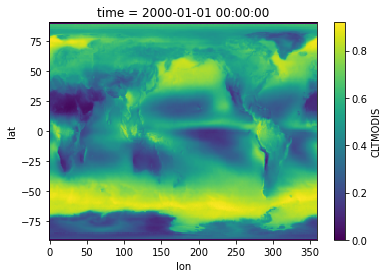

In [14]:
modis_final['CLTMODIS'].plot()